# The Anatomy of a Playlist: A Spotify API Tutorial
**Team**: Daisy Abbott, Hannah Guo, Amy Zhong

**Introduction:** The *Anatomy of a Playlist* tutorial aims to equip users (you!) with the skills to generate creative data visualizations, culminating in a personalized playlist cover "artwork" based on the mood of their own playlist. Through this tutorial, users will learn to fetch, analyze, and visualize their playlist data using the Spotify Web API. This API allows us to access extensive information on playlists and tracks; it contains especially rich metadata on individual tracks, such as their mood (valence) and tempo. Our tutorial will demonstrate how to generate artistic visualizations based on these scores. In addition to gaining familiarity working with APIs, users will work with the pandas, matplotlib, and seaborn libraries — essential tools for data analysis and visualization. By the completion of this tutorial, users will have a deeper understanding of the Spotify API as well as the ability to visually interpret and present their playlist data in an interesting and artistic way. This tutorial will be friendly to developers of all skill levels and will primarily serve users who are curious about the Spotify API; interested in learning about pandas, matplotlib, and seaborn; or who want to find further ways to express themselves and their music.

## Getting Started

Our very first step is to import the required Python libraries and get you access to the Spotify Web API. Run the next cell to install and import the libraries we'll be using.
- **requests**: This allows us to send HTTP requests elegantly, in Python. We "speak" to REST APIs such as the Spotify API through these HTTP methods.
- **pandas**: This is a great library for manipulating data sets. It has a data structure called a dataframe which is extremely useful; you can think of a dataframe as a table of data, with rows and columns.
- **matplotlib** and **seaborn**: These are popular libraries for creating data visualizations. Seaborn is built on top of Matplotlib and allows for more complex and aesthetically pleasing visualizations.

In [1]:
!pip install requests --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next, head over to [Spotify's Developer Dashboard](https://developer.spotify.com/dashboard/) and select "Create An App" to get your **client id** and **client secret**. You need to be logged into a premium Spotify account. Copy and paste your client id and secret below. Please keep these confidential!


These client credentials authorize you access to the Spotify API; feel free to learn more about the **OAuth 2.0** authorization protocol [here](https://auth0.com/intro-to-iam/what-is-oauth-2).

In [2]:
CLIENT_ID = 'YOUR_CLIENT_ID'
CLIENT_SECRET = 'YOUR_CLIENT_ID'

Now we just need to get your **access token**, which you can receive now that you have your client id and secret. This allows you to access protected resources from the API server. **If this step fails then there may be something wrong with your client ID and/or secret. Also note that this token has a limited lifespan so you may need to re-run this cell later on if you notice your API calls failing.**


We are granted the access token through a **POST request**. This is one of the **HTTP request methods** we will be using in this tutorial (learn more about [HTTP requests](https://www.w3schools.com/tags/ref_httpmethods.asp)).

In [3]:
auth_response = requests.post('https://accounts.spotify.com/api/token',
    {'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET}).json()
access_token = auth_response['access_token']
HEADERS = {'Authorization': 'Bearer {token}'.format(token=access_token)}

Note that we added our access token to `HEADERS`. This is an API request header — it provides additional information on the API requests we will be making. Here we are including our authentication credentials, but the request header can also be used to specify other things such as which version of the API to call.

## Data Fetching

We are ready to collect data on your favorite Spotify playlist! Assuming you are on Spotify's desktop app, you're going to navigate to the playlist you hope to analyze. Now we need to find its unique **playlist ID**. Click (...), scroll down to "Share", hold down the option key (Mac) / Alt key (Windows), and click on the "Copy Spotify URI" option that should appear. This will give you something that looks like `spotify:playlist:37i9dQZEVXbNG2KDcFcKOF`; the playlist ID in this case would be `37i9dQZEVXbNG2KDcFcKOF`.


Once you have located your playlist's ID, paste it below.

In [4]:
# Base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Replace with your playlist ID
playlist_id = '37i9dQZF1DX4SBhb3fqCJd' # YOUR_PLAYLIST_ID

Just like how each Spotify playlist has its unique ID, so does every song! In the following cells, we will:
- Fetch the track ID of each song in the playlist.
- Fetch catalog information and audio feature metadata for each track, using the track’s ID. This includes but is not limited to: 
    - genres
    - popularity
    - duration
    - tempo
    - valence
    - key
    - energy
    - danceability
    
(Don't worry about what each of these features mean, we'll be coming back to them in the next section of the tutorial!)
- Organize all data into a pandas dataframe and optionally save as a csv file.

The key to collecting all this data is the **GET method**. As its name suggests, we use this method to request data from the API.

Before we collect data on an entire playlist, let's play around with collecting data on a single song using the function below. For this example we selected Lana Del Rey's "Summertime Sadness."

In [5]:
def get_track_data(track_id):
    """ Given track_id, returns a dictionary
        containing the track's catalog information
        (e.g. name, artists, genres) and audio feature
        metadata (e.g. tempo, key, energy).
    """
    # Get each track's audio features
    audio = requests.get(BASE_URL + 'audio-features/' + track_id,
                         headers=HEADERS).json()
    # Get each track's catalog information
    track = requests.get(BASE_URL + 'tracks/' + track_id,
                         headers=HEADERS).json()
    artists = []
    genres = []
    for artist in track['artists']:
        artist_id = artist['id']
        artist_genres = requests.get(BASE_URL + 'artists/' + artist_id,
                                     headers=HEADERS).json()['genres']
        artists.append(artist['name'])
        genres.append(artist_genres)
    genres = [item for sublist in genres for item in sublist] # Flatten list
    
    # Combine into one dictionary and return
    audio.update({
        'name': track['name'],
        'artists': artists,
        'genres': genres,
        'popularity': track['popularity'],
        'explicit': track['explicit']
    })
    return audio

In [6]:
sample_track_id = '1Ist6PR2BZR3n2z2Y5R6S1'
get_track_data(sample_track_id)

{'danceability': 0.566,
 'energy': 0.647,
 'key': 1,
 'loudness': -6.815,
 'mode': 0,
 'speechiness': 0.0335,
 'acousticness': 0.0477,
 'instrumentalness': 0,
 'liveness': 0.121,
 'valence': 0.22,
 'tempo': 111.96,
 'type': 'audio_features',
 'id': '1Ist6PR2BZR3n2z2Y5R6S1',
 'uri': 'spotify:track:1Ist6PR2BZR3n2z2Y5R6S1',
 'track_href': 'https://api.spotify.com/v1/tracks/1Ist6PR2BZR3n2z2Y5R6S1',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Ist6PR2BZR3n2z2Y5R6S1',
 'duration_ms': 264773,
 'time_signature': 4,
 'name': 'Summertime Sadness',
 'artists': ['Lana Del Rey'],
 'genres': ['art pop', 'pop'],
 'popularity': 78,
 'explicit': False}

Cool! Now we know what information we have on each song.

Let's go ahead and do this for the playlist of your choice!

In [7]:
def get_playlist_data(playlist_id):
    """ Given playlist_id, returns a pandas DataFrame
        containing information on each track.
    """
    playlist_length = 50
    data = [] # Will contain info about the tracks on the playlist
    counter = 0 # Number of tracks appended to data

    while counter < playlist_length:
        limit = min(50, playlist_length-counter)
        playlist = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                                headers=HEADERS,
                                params={'limit': limit, 'offset': counter}).json()
        if counter==0:
            playlist_length = playlist['total']
        counter = min(counter+50, playlist_length) # Update counter
    
        for item in playlist['items']:
            data.append(get_track_data(item['track']['id']))
    df = pd.DataFrame(data)
    return df

In [8]:
playlist_df = get_playlist_data(playlist_id)
playlist_df.head(n=8) # View first 8 entries of dataframe

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.628,0.652,4,-6.065,0,0.0543,0.0106,0.001570,0.1450,0.552,...,spotify:track:4hbadZZrbM08KZIQZomWaI,https://api.spotify.com/v1/tracks/4hbadZZrbM08...,https://api.spotify.com/v1/audio-analysis/4hba...,185639,4,Not An Angel,[Tems],"[afro r&b, alte, nigerian pop]",66,False
1,0.774,0.609,6,-7.077,1,0.1260,0.1010,0.000000,0.1170,0.797,...,spotify:track:44G2gUVQvNNZ6w3i05tR4n,https://api.spotify.com/v1/tracks/44G2gUVQvNNZ...,https://api.spotify.com/v1/audio-analysis/44G2...,231109,4,Sensational (feat. Davido & Lojay),"[Chris Brown, Davido, Lojay]","[r&b, rap, afrobeats, afropop, azontobeats, gh...",77,True
2,0.673,0.722,3,-3.495,0,0.0755,0.0856,0.000000,0.1370,0.519,...,spotify:track:4WzfrBu4t3LVv1BSKWugbW,https://api.spotify.com/v1/tracks/4WzfrBu4t3LV...,https://api.spotify.com/v1/audio-analysis/4Wzf...,200256,4,Water,[Tyla],[],61,False
3,0.675,0.546,4,-7.716,0,0.0511,0.5560,0.004410,0.1670,0.607,...,spotify:track:7DswEZZthZ6piQpL25qGAM,https://api.spotify.com/v1/tracks/7DswEZZthZ6p...,https://api.spotify.com/v1/audio-analysis/7Dsw...,184258,4,On My Mama,[Victoria Monét],[alternative r&b],77,True
4,0.806,0.342,9,-7.503,1,0.0750,0.2010,0.017600,0.0758,0.937,...,spotify:track:1zgHn1EqUyA0HqNYMdJ5ia,https://api.spotify.com/v1/tracks/1zgHn1EqUyA0...,https://api.spotify.com/v1/audio-analysis/1zgH...,82581,4,Best Time,[Brent Faiyaz],"[r&b, rap]",77,True
5,0.753,0.669,7,-4.914,0,0.1040,0.0378,0.000000,0.1220,0.584,...,spotify:track:0J1YRLYhTG1MBosjidD7OI,https://api.spotify.com/v1/tracks/0J1YRLYhTG1M...,https://api.spotify.com/v1/audio-analysis/0J1Y...,247469,4,Good Good,"[USHER, Summer Walker, 21 Savage]","[atl hip hop, contemporary r&b, dance pop, pop...",75,True
6,0.773,0.685,5,-7.529,0,0.3090,0.0640,0.000007,0.1130,0.576,...,spotify:track:13eNzMdXHUinoWsxcRXTCW,https://api.spotify.com/v1/tracks/13eNzMdXHUin...,https://api.spotify.com/v1/audio-analysis/13eN...,237852,4,Feelings (feat. J Hus),"[Jorja Smith, J Hus]","[r&b, uk contemporary r&b, afroswing, grime, u...",69,False
7,0.735,0.328,5,-9.584,0,0.0681,0.3730,0.000307,0.1860,0.323,...,spotify:track:0Ani0foia32xeSDE2MdHWM,https://api.spotify.com/v1/tracks/0Ani0foia32x...,https://api.spotify.com/v1/audio-analysis/0Ani...,171218,4,Get Close,[Ari Lennox],[alternative r&b],66,False


If you would like to save a copy of this dataframe locally, the cell below saves your dataframe as a csv.

In [9]:
playlist_df.to_csv("playlist_data.csv")

## Data Analysis and Visualization
This is where the fun begins! You will learn to use **matplotlib** and **seaborn** in conjunction with **pandas**
to analyze and visualize your playlist data. We will start with some simple data analysis, then walk you through data visualizations of increasing complexity.

### Data Analysis
After procuring your table with information about each track in your playlist, you may want to ask (and answer!) some questions about it.

For example, say you want to know the key signature of a particular song.

Spotify represents key signatures as numbers, therefore to make it easy to see exactly which key a given song is in, let's create a mapping to use in the `get_song_info` function.

In [10]:
# Define the key mapping, Numbers correspond to key signatures.
key_mapping = {
    0: 'C',
    1: 'C♯/D♭',
    2: 'D',
    3: 'D♯/E♭',
    4: 'E',
    5: 'F',
    6: 'F♯/G♭',
    7: 'G',
    8: 'G♯/A♭',
    9: 'A',
    10: 'A♯/B♭',
    11: 'B',
}

Great! Now let's go ahead and define a function that returns some specific feature of a track. An example is included below as well, where we get the key signature of a song.

In [11]:
def get_song_info(df, song_name, info_key):
    """
    Given a DataFrame, song name, and desired information key,
    this function returns the desired feature of the given song.
    """
    # Encase in a try-catch so that if the song named is typed incorrectly 
    # or is not found within the df there won't be an error.
    try:
        # Case-insensitive search
        song_info_series = df[df['name'].str.lower() == song_name.lower()][info_key]
        if not song_info_series.empty:  # Check if the series is not empty
            song_info = song_info_series.values[0]  # Extract the first element
            return song_info
        else:
            print(f"Song '{song_name}' not found in the playlist.")
            return None
    except KeyError:
        print(f"Error: The column '{info_key}' does not exist in the DataFrame.")
        return None

In [16]:
# Get the key of your favorite song
song_name = "Love Language" # YOUR_SONG_NAME
info_key = "key"
song_key = get_song_info(playlist_df, song_name, info_key)

if song_key is not None: # "As long as the key is there"
    music_key = key_mapping.get(song_key, 'Note') # Call key mapping
    print(f'The key of "{song_name}" is {music_key}.')

The key of "Love Language" is A.


Awesome! Now what if you want to find which song in your playlist is the most danceable?

Let's start by sorting the songs in the playlist by most danceable. Luckily, pandas has a `sort_values` function we can directly call.

In [17]:
# Sort the DataFrame by danceability in descending order
sorted_playlist = playlist_df.sort_values(by='danceability', ascending=False)

Great. From there, we can get the track at the first index, and then print it!

In [18]:
# Get the most danceable song
most_danceable_song = sorted_playlist.head(1).reset_index()

# Print information about the most danceable song
print("Most Danceable Song:")
print(most_danceable_song[[ 'name', 'danceability']])

Most Danceable Song:
        name  danceability
0  Moonlight         0.895


Let's try something else. Do you think your highest scoring song in terms of danceability also has a high valence score? (By Spotify's definition, a higher valence score corresponds to a more positive and cheerful song.)

Let's find out:  

In [19]:
song_name = "Moonlight" # Replace with the song printed above

# Get the index of the song
index_of_song = playlist_df[playlist_df['name'] == song_name].index[0]

# Get the valence of the song
valence_of_song = playlist_df.loc[index_of_song, 'valence']

print(f"Valence of '{song_name}': {valence_of_song}")

Valence of 'Moonlight': 0.368


Cool! What do you think: is there a **correlation** between danceability and valence? We'll come back to this question at the end of the next section.

Now let's switch gears and look at visualizing our playlist data!

### Data Visualization!

Let's try to visualize the data on a **bar plot**. For example, we can plot the loudness of each song and see the representation on axis.

For this task we will be using the **matplotlib** library, which we imported at the beginning of the tutorial. Note that it is industry standard to `import matplotlib.pyplot as plt`, so if you see `plt` in the following sections, remember that this is us calling matplotlib!

Before plotting, let us sort the tracks in your playlist by loudness: 

In [20]:
loudness_sorted_df = playlist_df.sort_values(by='loudness')

OK. We're ready to specify the details of our plot.

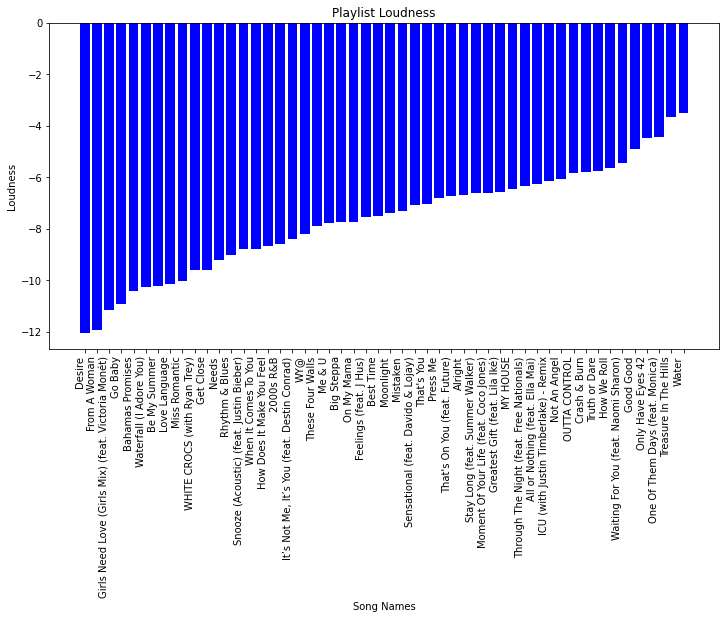

In [21]:
# Plot size
plt.figure(figsize=(12, 6))
# Type of graph (in this case, bar), specifying loudness as subject being graphed, and the color
plt.bar(loudness_sorted_df['name'], loudness_sorted_df['loudness'], color='blue')
# Label the x axis to be track names
plt.xlabel('Song Names')
# And the y to be the loudness
plt.ylabel('Loudness')
# Give the plot a title
plt.title('Playlist Loudness')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, ha='right') 
# Show the plot
plt.show()

Depending on the songs in your playlist, some song names may be too long and affect the readability of the plot. If that is the case, let's address this with some clever **list comprehension** over the x-axis labels and then re-attempt the bar plot.

In [22]:
# Before performing list comprehension, we first need to convert this pandas Series to a list
song_names = loudness_sorted_df['name'].tolist()
# List comprehension: if the song name is longer than 20 characters, truncate it and add '...' to the end
truncated_song_names = [name[:20] + '...' if len(name) > 20 else name for name in song_names]

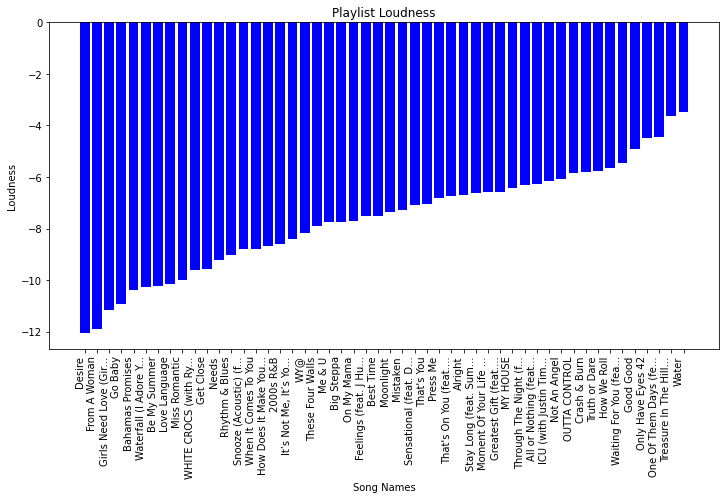

In [23]:
plt.figure(figsize=(12, 6))
# Note that we replaced `loudness_sorted_df['name']` with `truncated_song_names`
plt.bar(truncated_song_names, loudness_sorted_df['loudness'], color='blue')
plt.xlabel('Song Names')
plt.ylabel('Loudness')
plt.title('Playlist Loudness')
plt.xticks(rotation=90, ha='right')
plt.show()

Good job!

Let's try another plot. What about a **pie chart** showing the distribution of different artists in your playlist? Before plotting, we should examine what kind of data is stored in the `artists` column of our DataFrame. Run the code below to see an example.

In [24]:
playlist_df['artists'][0] # Artist(s) of the first song in DataFrame

['Tems']

You may have noticed that for each song, the name(s) of its artist(s) are stored in a list of strings. That is, the `artists` column of the DataFrame is a pandas Series of lists of strings. To be able to plot this in a pie chart, we need a list of artist names and a list of their counts — let's do that.

In [25]:
# Flatten into one list of all artist names
all_artists = [artist for artists in playlist_df['artists'] for artist in artists]
# Get counts of each artist using value_counts, a function provided by pandas
artist_counts = pd.Series(all_artists).value_counts()
# Uncomment the print statement if you'd like!
# print(artist_counts)

With that, we are ready to start plotting.

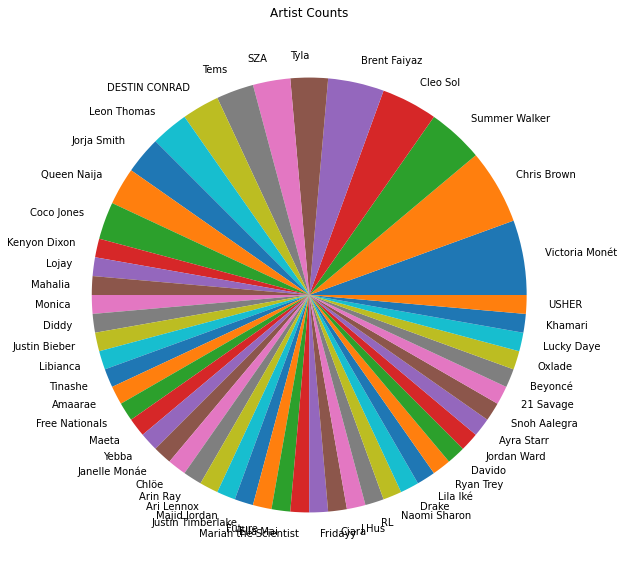

In [26]:
# Plot size
plt.figure(figsize=(10, 10))
# Type of graph (pie), specifying artist_counts as subject being graphed
plt.pie(artist_counts, labels=artist_counts.index)
# Give the plot a title
plt.title('Artist Counts')
# Show the plot
plt.show()

It worked (hopefully)! But if you're anything like us and listen to a wide range of artists, you might notice that your visualization has crowded labels and a slightly chaotic color scheme. Let's improve it!

Instead of displaying all artists, how about we show your top 5 artists and display the rest of the pie as "Other"? Artist names can be lengthy, so another thing we can do to improve readability is to move the labels of each slice to a legend on the side.

In addition, let's change the colors of the pie chart. We could manually select the color of each slice, but the **seaborn** library has a pretty set of pre-defined color palettes! This is the second data visualization library we will be featuring in our tutorial; it is built on top of matplotlib but allows for more advanced and more aesthetic plots. (Spoiler alert: you will be working more with seaborn in the next section of the tutorial as well.)

We already picked a color palette for you, but if you'd like to select something different, you can read more about seaborn color palettes [here](https://seaborn.pydata.org/tutorial/color_palettes.html).

In [27]:
n = 5 # Feel free to adjust this number
top_artists = artist_counts.head(n)
other_artists = artist_counts.iloc[n:].sum()
# Concatenate two Series
artist_counts_adjusted = pd.concat([top_artists, pd.Series({'Other': other_artists})])

# Uncomment the print statement if you'd like!
# print(artist_counts_adjusted)

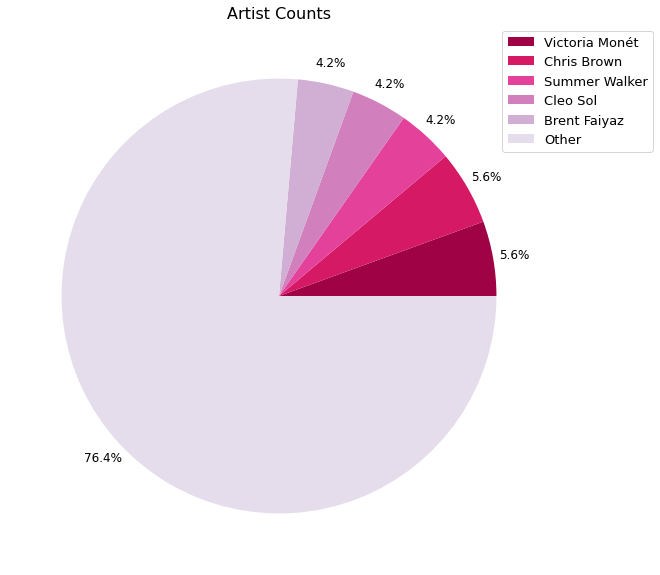

In [28]:
plt.figure(figsize=(10, 10))
plt.pie(
    artist_counts_adjusted, # Switched from artist_counts to artist_counts_adjusted
    autopct = '%.1f%%', # Displays percentage with 1 decimal place
    pctdistance = 1.1, # Relative distance of percentage from center of pie
    colors = sns.color_palette("PuRd_r"), # Apply seaborn color palette
    textprops = {'size': 12} # Font size
    )
plt.title(
    label = 'Artist Counts',
    fontdict={"fontsize":16} # Change font size of title
)
# Move labels to a legend
plt.legend(
    artist_counts_adjusted.index, 
    loc = "upper right", # Position of legend, relative to specified coordinates
    bbox_to_anchor = (1.2, 1), # Specify desired coordinates of legend
    prop = {'size': 13} # Font size
)
# Show the plot
plt.show()

Cool, now let's answer the question at the end of the data analysis section: is there any **correlation** between danceability and valence? Let's plot these two features on a **scatter plot**.

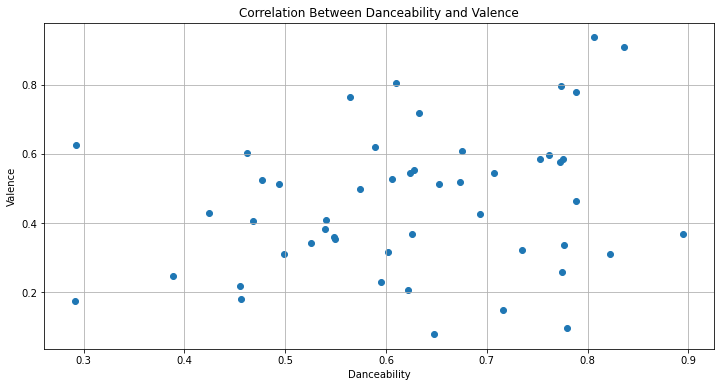

In [29]:
plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['danceability'], playlist_df['valence'])
plt.title('Correlation Between Danceability and Valence')
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

Can you tell from just the graph? To go one step further, let us also calculate the **correlation coefficient**. This statistical measure has values ranging from -1 to 1; where -1 means a perfect negative correlation, 0 means no correlation, and 1 means a peferct positive correlation.

In [30]:
correlation_coefficient = playlist_df['danceability'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.2450041749153473


Did you find any correlation?

Finally, before moving onto the final section of our tutorial, let's summarize the features of our playlist so that we have a better picture of the data we are working with. 

Let's begin by creating a bar plot for the means of all our data.  

In [31]:
# Using the .mean method of pandas DataFrames, we can create a type Series of the means of the DataFrame
# numeric_only=True specifies the DataFrame to only include numeric values when calculating the mean
playlist_means = playlist_df.mean(numeric_only=True)
playlist_cols = playlist_means.index.tolist()

# Let's take a look at what this series of playlist_means looks like
print("playlist_means:")
print(playlist_means)

playlist_means:
danceability             0.625740
energy                   0.510200
key                      5.300000
loudness                -7.631340
mode                     0.380000
speechiness              0.123840
acousticness             0.359292
instrumentalness         0.014187
liveness                 0.173410
valence                  0.459700
tempo                  119.640280
duration_ms         197511.920000
time_signature           3.880000
popularity              66.740000
explicit                 0.460000
dtype: float64


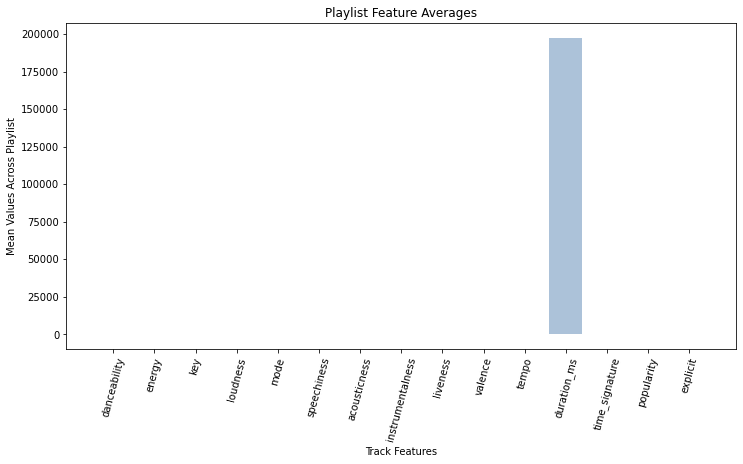

In [32]:
# Now, let's create a bar plot of this data using the matplotlib library
plt.figure(figsize=(12, 6))
plt.bar(playlist_cols, playlist_means, color="xkcd:cloudy blue")
plt.xlabel("Track Features")
plt.ylabel("Mean Values Across Playlist")
plt.title("Playlist Feature Averages")
plt.xticks(rotation=75)
plt.show()

Oh no! Why is it that we cannot see any of the other data points except for `duration_ms`? That's because the height of that column is in the 20,000s, whereas the rest of our data lies around and below the 100 range, with the majority of our data lying around the 0 - 1 range. Each variable is measuring something different: some variables are a measurement of quantity (e.g. `duration`), whereas others are a measurement of scale (e.g. `danceability`). 

Knowing this, what is a better way to visualize our playlist data? Let's split our data into three categories and create three separate bar plots to visualize our data: 
1. data with values from 0 - 1, 
2. data with values from -10 - 10 ( [0,1] non-inclusive), and 
3. data with values greater than 10

Let's begin creating a subset of our `playlist_means` wherein the values are between 0 & 1. 

First, let's lump "popularity" in this set of data as it is a feature which has values ranging from 0 - 100.

In [33]:
# We will do this by locating the index "popularity" and replacing its value
playlist_means.loc["popularity"] = playlist_means.loc["popularity"] / 100

Next, we want to create a list of columns to exclude from our DataFrame, before creating a new Series of means.

In [34]:
# Initialize the columns to be excluded
zero_to_one_exclude = []

# Looping into the indices (column names) of our playlist_means
for col_name in playlist_means.index:
    # if the associated number is less than 0 or greater than 1
    if (playlist_means[col_name] < 0) or (playlist_means[col_name] > 1):
        # add the column name to exclude_cols
        zero_to_one_exclude.append(col_name)

# Let's take a look at what this list consists of
print(zero_to_one_exclude)

# Now, let's create a new series of means
# The drop method drops the columns given
zero_to_one_means = playlist_df.drop(columns=zero_to_one_exclude).mean(numeric_only=True)
print(zero_to_one_means)

# We need to change the "popularity" data in our zero_to_one_means as it has only been changed in playlist_means
zero_to_one_means.loc["popularity"] = zero_to_one_means.loc["popularity"] / 100

zero_to_one_cols = zero_to_one_means.index.tolist()

['key', 'loudness', 'tempo', 'duration_ms', 'time_signature']
danceability         0.625740
energy               0.510200
mode                 0.380000
speechiness          0.123840
acousticness         0.359292
instrumentalness     0.014187
liveness             0.173410
valence              0.459700
popularity          66.740000
explicit             0.460000
dtype: float64


Before creating our bar plots, let's set up the data for the other two brackets so that we may view all the plots together. Let's move onto creating the subset of `playlist_means` with values between -10 and 10, but non-inclusive of [0, 1].

Similar to our `zero_to_one_means` subset, we want to create a list of columns to exclude, before moving onto creating a new series of means for this subset of data. 

In [35]:
# We want to exclude all the data that was included for zero_to_one_means, 
# so let's remove the columns from zero_to_one_exclude from a copy of playlist_cols
negten_to_ten_exclude = playlist_cols[::]
for col in zero_to_one_exclude:
    negten_to_ten_exclude.remove(col)

# Next, we want to exclude the data that has values > 10 and < -10
for i in range(len(playlist_means)):
    if ((playlist_means[i] > 10) or (playlist_means[i] < -10)):
        # Appending these columns to our exclude list 
        negten_to_ten_exclude.append(playlist_means.index[i])

# Creating our means for this bracket of data
negten_to_ten_means = playlist_df.drop(columns=negten_to_ten_exclude).mean(numeric_only=True)
# Let's look at negten_to_ten_means in comparison to our playlist_means data to verify a successful bracketing
print("negten_to_ten_means:")
print(negten_to_ten_means)
print("playlist_means")
print(playlist_means)

negten_to_ten_means:
key               5.30000
loudness         -7.63134
time_signature    3.88000
dtype: float64
playlist_means
danceability             0.625740
energy                   0.510200
key                      5.300000
loudness                -7.631340
mode                     0.380000
speechiness              0.123840
acousticness             0.359292
instrumentalness         0.014187
liveness                 0.173410
valence                  0.459700
tempo                  119.640280
duration_ms         197511.920000
time_signature           3.880000
popularity               0.667400
explicit                 0.460000
dtype: float64


Indeed we have truncated our data to be the bracket we want! Let's now from this data create a list of columns.

In [36]:
negten_to_ten_cols = negten_to_ten_means.index.tolist()

Finally, let's create the subset of `playlist_means` with values greater than 10. Again, we will want to create a list of columns to exclude, before moving onto creating a new Series of means for this subset of data. 

In [37]:
# We want to remove all the data from zero_to_one_means & negten_to_ten_means
# So, let's remove the columns which appear in the exclude lists of both data brackets
greater_ten_exclude = playlist_cols[::]
for col in zero_to_one_exclude:
    if col in negten_to_ten_exclude:
        greater_ten_exclude.remove(col)
        
# Here is what is in the list
print(greater_ten_exclude)

# Now, we can create the means for this bracket of data
greater_ten_means = playlist_df.drop(columns=greater_ten_exclude).mean(numeric_only=True)
print(greater_ten_means)

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'time_signature', 'popularity', 'explicit']
tempo             119.64028
duration_ms    197511.92000
dtype: float64


There is still a huge difference between the mean tempo and the mean duration_ms of our playlist. Let's change the unit of duration_ms to be more appropriately understood 

In [38]:
greater_ten_means.loc["duration_ms"] = playlist_means.loc["duration_ms"] / 1000
# Renaming the index to update the unit appropriately
greater_ten_means.rename({'duration_ms': 'duration_s'}, inplace=True)

print(greater_ten_means)

tempo         119.64028
duration_s    197.51192
dtype: float64


Great! We can see that data and its index have been appropriately updated. Let's now create a list of columns from this data

In [39]:
greater_ten_cols = greater_ten_means.index.tolist()

Now that we have appropriately truncated our data to be better visualized in bar plots, let's plot them using the plotting techniques learned earlier in the tutorial!

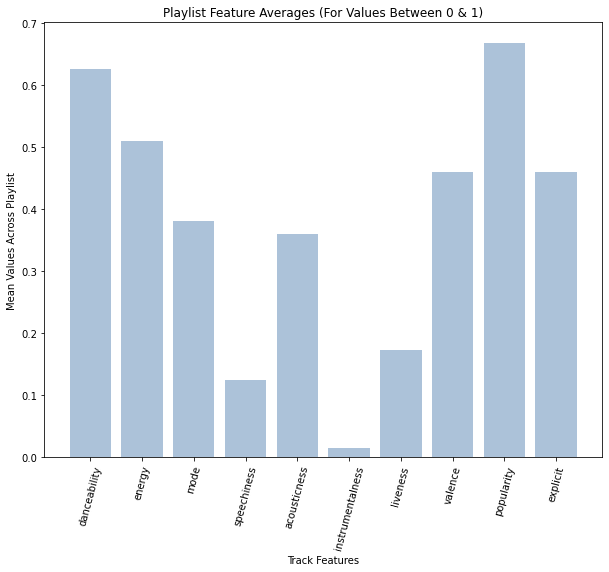

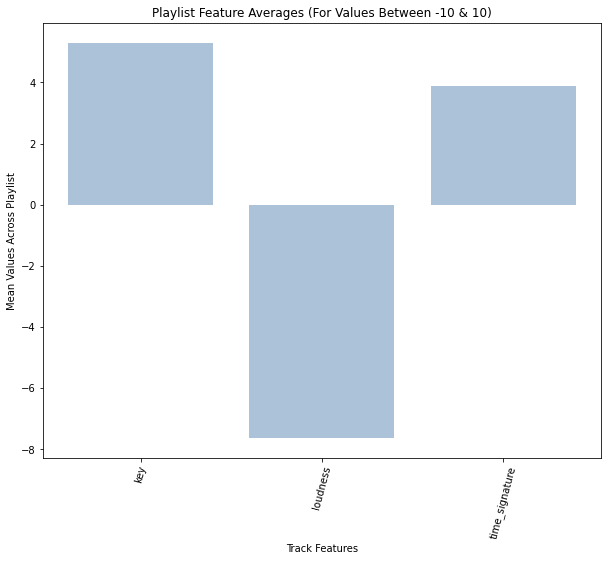

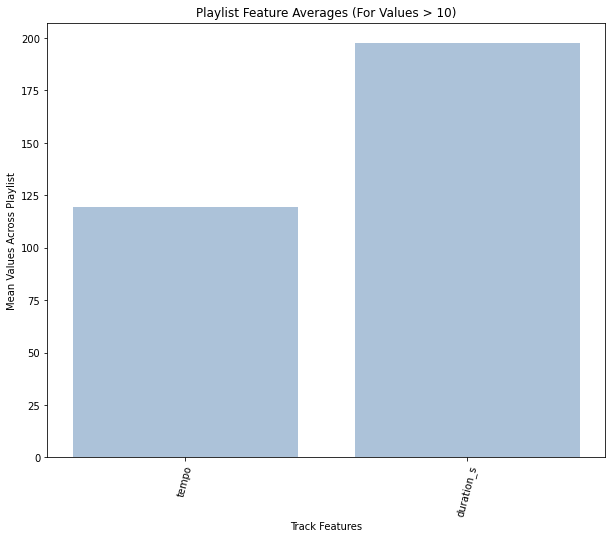

In [40]:
# Bar plot for values between 0 & 1
plt.figure(figsize=(10, 8))
plt.bar(zero_to_one_cols, zero_to_one_means, color="xkcd:cloudy blue")
plt.xlabel("Track Features")
plt.ylabel("Mean Values Across Playlist")
plt.title("Playlist Feature Averages (For Values Between 0 & 1)")
plt.xticks(rotation=75)
plt.show()

# Bar plot for values between -10 and 10, excluding [0, 1]
plt.figure(figsize=(10, 8))
plt.bar(negten_to_ten_cols, negten_to_ten_means, color="xkcd:cloudy blue")
plt.xlabel("Track Features")
plt.ylabel("Mean Values Across Playlist")
plt.title("Playlist Feature Averages (For Values Between -10 & 10)")
plt.xticks(rotation=75)
plt.show()

# Bar plot for values greater than 10 
plt.figure(figsize=(10, 8))
plt.bar(greater_ten_cols, greater_ten_means, color="xkcd:cloudy blue")
plt.xlabel("Track Features")
plt.ylabel("Mean Values Across Playlist")
plt.title("Playlist Feature Averages (For Values > 10)")
plt.xticks(rotation=75)
plt.show()

Now that we have visually represented our Spotify playlist data with graphs using pandas and matplotlib, let's finally advance onto the final section: data as art!

## Data as Art

We've had some practice with basic data visualizations. It's time to explore more advanced and artistic data visualizations! At the end of this section you will have generated a plot that you can use as cover art for your favorite playlist.

In this section we will be using seaborn — a library we introduced earlier — to create smooth Kernel Density Estimation (KDE) graphs as our playlist artwork. Before we do this, however, let's first create our own color palettes (or, in the language of matplotplib, a colormap). We will use these color maps to color and visualize our data.

Let's start by importing the `colors` module of matplotlib and the `numpy` library.

In [41]:
import matplotlib.colors as mcolors
import numpy as np

Now, let's choose the colors we want for our color map. We can begin this process by thinking about what sorts of colors would represent our playlist well. Some examples are: warm colors for playlists with a happier vibe and cool colors for a playlist with a sadder vibe. We just learned how to look at the mean scores for all the different features in our playlist; we can reference these to gain a better quantitative understanding of our playlist mood.

With these moods in mind, feel free to browse [Pinterest](https://www.pinterest.com) and use this [image-to-hex conversion website](https://imagecolorpicker.com/en) to convert an image into colors with respective hex values!

Let's now create an array of strings, wherein the strings are the the hex values of the colors. There are some important things to note:
1. Feel free to pick multiple colors! However, the playlist art visualization will look more coherent if the colors chosen have the same warmth, e.g. warm or cool colors, but not together.
2. We will being using a high number of bins to make our color palettes smooth and gradient; don't worry about trying to pick many colors in between the ones you've already chosen to make it look more like a gradient. More on this later!
3. The ordering of the colors in the list is important! Make sure to put the colors in a sequentially sensible order, e.g. light to dark.
4. We will also be creating a reverse colormap by reversing the colors in the list. Just follow along!

In [42]:
colors1 = ['#f7f4ed', '#f0c51c', '#ee7526', '#ef4255'] # Replace with your own

# Make a copy of colors1 array... more on why we do this later!
colors1_reverse = colors1[::]  
colors1_reverse.reverse()

Next, we will define the number of bins to be used for our colormap. The number of bins determines how many discrete colors there are in our colormap; a higher number of bins n leads to a smoother gradient. As a general rule, let's use `num(colors) * 200` for a smooth gradient.

In [43]:
n_bins = len(colors1) * 200 # Feel free to replace

Now, let's create our colormap using the `LinearSegmentedColormap` class as part of `matplotlib.colors`. 

In [44]:
# Creating a LinearSegmentedColormap 
def make_colormap(cmap_name, colors, num_bins=n_bins):
    """
    Given the name of colormap (string), a string list of colors in their hex values, and a number of bins
    (predetermined if not provided), generate, return, and display a colormap
    """
    # Generating a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=num_bins)

    # Create a one-dimensional array to serve as stand-in data so that the colormap may be displayed well
    gradient_multi = np.linspace(0, 1, 256)
    # Stacking one array on top of another to visually  thicken it
    gradient_multi = np.vstack((gradient_multi, gradient_multi)) 

    # Display colormap
    # Dpi = dots-per-inch (pixel density)
    plt.figure(figsize=(3, 1), dpi=300)  # 300 dpi is the ideal dpi for Spotify playlist covers *
    plt.imshow(gradient_multi, aspect='auto', cmap=cmap)
    plt.title(cmap_name)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
    return cmap

Let's now use the above defined function to create and visualize some colormaps!

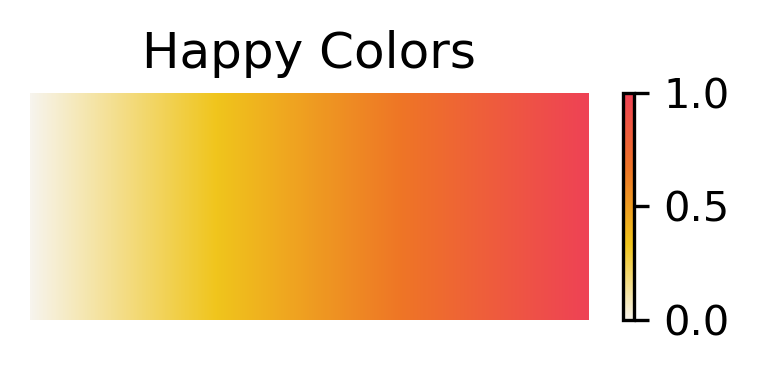

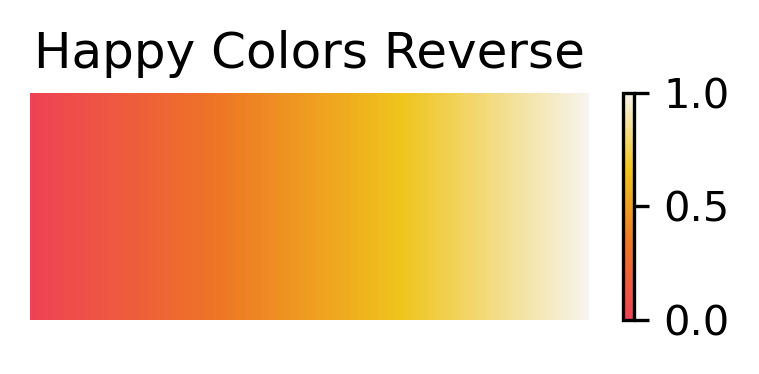

In [45]:
# Sample
cmap_name = 'Happy Colors'
happy_colors = make_colormap(cmap_name, colors1, n_bins)

cmap_name_reverse = 'Happy Colors Reverse'
happy_colors_reverse = make_colormap(cmap_name_reverse, colors1_reverse, n_bins)

# Replace the above with your own colormaps, following the following format:
# cmap_name = 'YOUR_CMAP'
# map_name = make_colormap(cmap_name, colors1, n_bins)
#
# cmap_name_reverse = 'YOUR_CMAP_REVERSE'
# map_name_reverse = make_colormap(cmap_name_reverse, colors1_reverse, n_bins)

As an aside, it is definitely possible to use the **pre-defined matplotlib colormaps** instead! Run the following method to see a comprehensive list of all mplt built-in colormaps.

In [46]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

Now that we've created our own colormaps, let's move onto generating our playlist artwork. As mentioned earlier, we will be doing this using Kernel Density Estimation (KDE) plots.

Consider the following function:

In [47]:
figure_count = 0

def generate_artwork(df, x, y, cmap, weights):
    """
    Given a dataframe and the coordinates to be mapped onto the kernel density estimate (KDE) plot, generate a KDE
    plot to become the playlist art.
    """
    global figure_count
    
    plt.figure(figsize=(2, 2), dpi=300)
    fig = sns.kdeplot(data=df,       # Obtain data from the pandas dataframe provided
                x=x,                 # Choose variable and its corresponding data for x axis
                y=y,                 # Choose variable and its corresponding data for y axis
                cmap=cmap,           # Choose colormap to be used
                weights=weights,     # Choose data for which to weight the (x,y) coordinates
                thresh=0,            # 0 so as to display all data & not ignore any data
                levels=500,          # Similar to bins for a colormap; governs smoothness for KDE plot
                fill=True            # Fill in areas with no data
                )
    
    # Optionally, customize the plot with titles, labels, etc. 
    # Uncomment to customize, but be sure to comment out "plt.axis('off')" below!
#     plt.title('Playlist Aura')
#     plt.xlabel(x)
#     plt.ylabel(y)

    # Otherwise, comment out the above customization features & turn off the axis for just the image
    plt.axis('off')

    # Display & save the plot to local folder!
    plt.show()
    
    if figure_count == 0:
        figure_title = "Playlist Aura.png"
        fig.figure.savefig(figure_title, bbox_inches='tight')
    else:
        figure_title = "Playlist Aura(" + str(figure_count) + ").png"
        fig.figure.savefig(figure_title, bbox_inches='tight')
    # Global var to keep track of how many figures have been created so the saved images don't overwrite each other
    figure_count += 1

Using this function, some `playlist_df` variables and its corresponding data, and a colormap, let's generate some artwork!

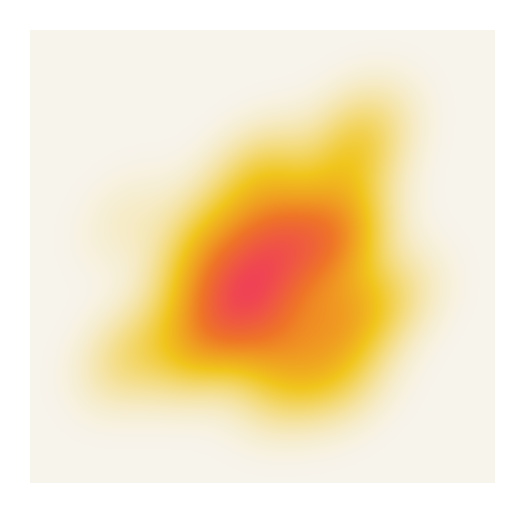

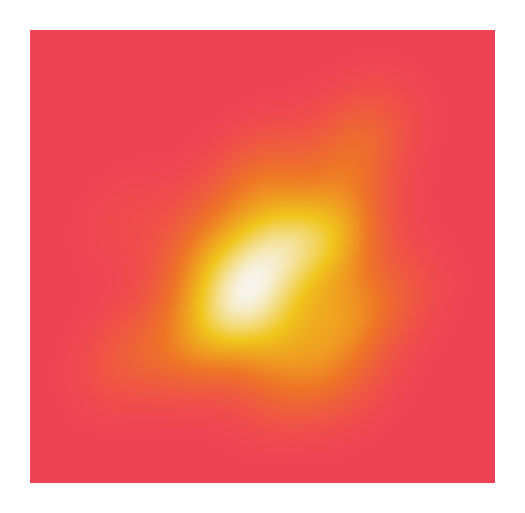

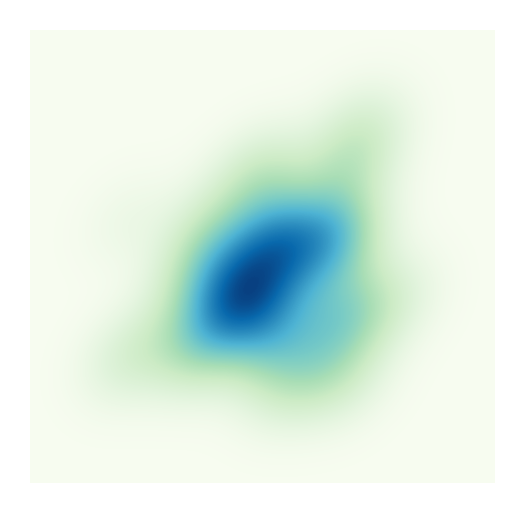

In [48]:
# Make sure colormap name is not in ""
# How to pick what data for x,y? Well, how do we want the location data to correspond to our playlist?
    # e.g. for a happy playlist, a plausible option would be to plot against "danceability" & "valence"
    
generate_artwork(playlist_df, "danceability", "valence", happy_colors, "loudness")
generate_artwork(playlist_df, "danceability", "valence", happy_colors_reverse, "loudness")
# GnBu is a mplt built-in colormap
generate_artwork(playlist_df, "danceability", "valence", "GnBu", "loudness") 

And that's it! There you have your very own playlist cover artworks generated from the playlist data.

**Data is art!**

We hope this tutorial was helpful in your understanding of APIs, data analysis, and data visualization.